In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestRegressor
import subprocess
from sklearn.model_selection import RandomizedSearchCV
import sys
import math
import os
import shutil
import glob
import shap

cmap='viridis'
sys.path.insert(1, '../')
from LibHelperFuncs import *

rstate = 0
np.random.seed(0)
njob = -1
global_trees = 1000

In [2]:
originalDat = np.genfromtxt("../../Data/data_bas_preprocessing.csv", delimiter=',')
originalDat_pd = pd.read_csv("../../Data/data_bas_preprocessing_pd.csv")

X = originalDat[:,:-1]
Y = originalDat[:,-1]
C = originalDat_pd.columns

lower_thres = 1e-3

files = []
objectives = ['ISM_gaus_homogeneous_0.5.csv', 'pca_sparse_homogeneous_0.5.csv',\
              "ISM_squa_homogeneous_0.5.csv", "ISM_poly_homogeneous_0.5.csv",\
              'pca_standard.csv', 'nmf_H_matrix_homogeneous_0.5.csv', 'pca_homogeneous_0.5.csv']

In [3]:
rf = RandomForestRegressor(n_estimators=global_trees, random_state=rstate, n_jobs=-1)
rf.fit(X, Y)

rff = rf.feature_importances_

rffpm = permutation_importance(rf, X, Y, n_repeats=10, n_jobs=-1, random_state=rstate)

exp = shap.TreeExplainer(rf, feature_perturbation='tree_path_dependant')
s_vals = exp.shap_values(X, approximate=True)
ov_shap = np.mean(np.abs(s_vals), axis=0)


In [4]:
p_imp = rffpm['importances_mean']

In [6]:
cvrf = []
cvsh = []
cvpm = []
lrange = range(5, 101, 1)

for l in lrange:
    print(l)
    X_r = X[:,np.argsort(rff)[::-1][:l]]

    score = cross_val_score(rf, X_r, Y, cv=5, n_jobs=njob, scoring='neg_mean_squared_error')
    cvrf.append(np.mean(np.abs(score)))
    
    X_r = X[:,np.argsort(p_imp)[::-1][:l]]

    score = cross_val_score(rf, X_r, Y, cv=5, n_jobs=njob, scoring='neg_mean_squared_error')
    cvpm.append(np.mean(np.abs(score)))
    
    X_r = X[:,np.argsort(ov_shap)[::-1][:l]]

    score = cross_val_score(rf, X_r, Y, cv=5, n_jobs=njob, scoring='neg_mean_squared_error')
    cvsh.append(np.mean(np.abs(score)))

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


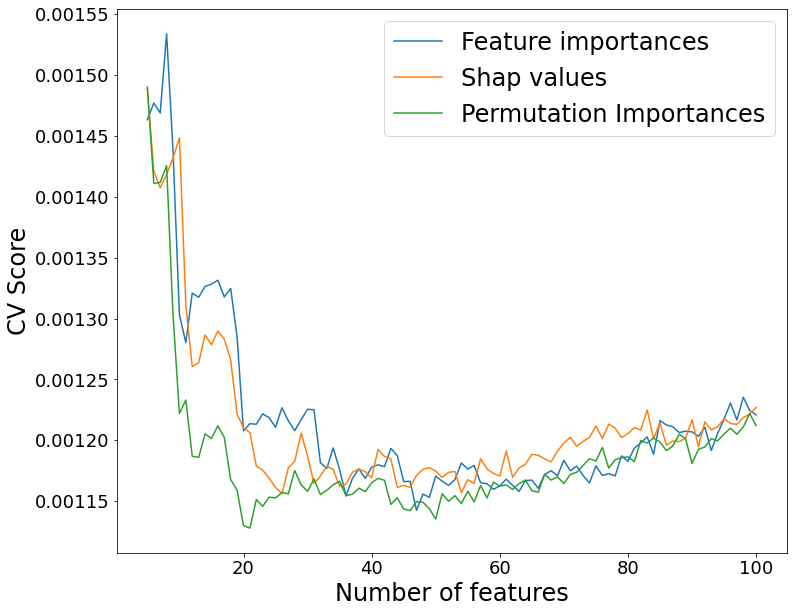

In [7]:
plt.figure(figsize=(12,10))

plt.plot(lrange, cvrf, label='Feature importances')
plt.plot(lrange, cvsh, label='Shap values')
plt.plot(lrange, cvpm, label='Permutation Importances')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=24)

plt.xlabel("Number of features", fontsize=24)
plt.ylabel("CV Score", fontsize=24)

plt.legend(fontsize=24)